In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.videotag import VIDEOtagGenerator
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json
import skimage.io

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())


args_input_json = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/instances.json'
args_image_dir = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/images'
args_image_log_dir = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/logs'
args_output_json = '/Users/luke/Documents/ml_datasets/new/videotag/0101_0102/result/instances.json'
ROOT_DIR = os.getcwd()


/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/luke/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# model = keras.models.load_model('/Users/luke/Documents/ml_models/resnet50_coco_best_v1.2.2.h5', custom_objects=custom_objects)
# model = keras.models.load_model('/Users/luke/Documents/ml_models/deep/cate50/resnet50_csv_epoch_50_loss_0.90363.h5', custom_objects=custom_objects)
model = keras.models.load_model('/Users/luke/Documents/ml_models/videotag/resnet50_coco_epoch_40_loss_0.04253.h5', custom_objects=custom_objects)

/Users/luke/.pyenv/versions/3.6.3/envs/py36/lib/python3.6/site-packages/keras/models.py:274: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  sample_weight_mode=sample_weight_mode)


# Load COCO Dataset 

In [5]:
coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush']


FILE_CATEGORY_MAP = "../assets/json/category.json"

# Load DeepFashion Dataset

In [6]:
coco_class_names = ['Anorak','Blazer','Blouse','Bomber','Button-Down','Cardigan',
                    'Flannel','Halter','Henley','Hoodie',
                    'Jacket','Jersey','Parka','Peacoat','Poncho','Sweater','Tank',
                    'Tee','Top','Turtleneck','Capris','Chinos','Culottes','Cutoffs','Gauchos',
                    'Jeans','Jeggings','Jodhpurs','Joggers','Leggings','Sarong','Shorts',
                    'Skirt','Sweatpants','Sweatshorts','Trunks','Caftan','Cape','Coat',
                    'Coverup','Dress','Jumpsuit','Kaftan','Kimono','Nightdress','Onesie',
                    'Robe','Romper','Shirtdress','Sundress']

FILE_CATEGORY_MAP = "../assets/json/category_map_deep.json"

In [3]:
coco_class_names = ['upper-body', 'lower-body', 'full-body']

FILE_CATEGORY_MAP = "../assets/json/category_map_deep.json"

# Load COCO+Deepfashion Dataset

In [12]:
coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
                'bus', 'train', 'truck', 'boat', 'traffic light',
                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                'kite', 'baseball bat', 'baseball glove', 'skateboard',
                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                'teddy bear', 'hair drier', 'toothbrush',
            'Anorak','Blazer','Blouse','Bomber','Button-Down','Cardigan',
                'Flannel','Halter','Henley','Hoodie',
                'Jacket','Jersey','Parka','Peacoat','Poncho','Sweater','Tank',
                'Tee','Top','Turtleneck','Capris','Chinos','Culottes','Cutoffs','Gauchos',
                'Jeans','Jeggings','Jodhpurs','Joggers','Leggings','Sarong','Shorts',
                'Skirt','Sweatpants','Sweatshorts','Trunks','Caftan','Cape','Coat',
                'Coverup','Dress','Jumpsuit','Kaftan','Kimono','Nightdress','Onesie',
                'Robe','Romper','Shirtdress','Sundress']

FILE_CATEGORY_MAP = "../assets/json/category_map_deep.json"

# Load Category Map

In [4]:
###################################################################
# Load VIDEOtag, COCO category 맵핑 데이타
# COCO Model에서 검출된 class와 VIDEOtag에 미리 정해져 있는 class매칭을 위해 사용
###################################################################
map_data = open(FILE_CATEGORY_MAP).read()
tmp_vt_coco_cate_map = json.loads(map_data)["categories"]

# NOTE : 빠른 검색을 위해 dictionary로 생성
vt_coco_cate_map = {}
for cate_data in tmp_vt_coco_cate_map:
    vt_coco_cate_map[cate_data['id']] = cate_data


json_data = open(args_input_json).read()
data = json.loads(json_data)

# NOTE : VIDEOtag Data (원본)
vt_anno_ary = data['annotations']
vt_img_ary = data['images']
vt_cate_ary = data['categories']

# NOTE : VIDEOtag Data (검색용)
vt_anno_ids_of_imageids = {}
vt_anno_dic = {}
vt_cate_ary_dic = {}

for anno in vt_anno_ary:
    vt_anno_dic[anno['id']] = anno

# for cate in vt_cate_map_ary:
#     vt_cate_ary_dic[cate['id']] = cate

for image in vt_img_ary:
    anno_ids = []
    image_id = image['id']

    for anno in vt_anno_ary:
        anno_img_id = anno['image_id']
        anno_id = anno['id']
        if anno_img_id == image_id:
            anno_ids.append(anno_id)

    vt_anno_ids_of_imageids[image_id] = anno_ids

def getAnnosByImgId(img_id):
    anno_ids = vt_anno_ids_of_imageids[img_id]
    result = []
    for anno_id in anno_ids:  
        result.append(vt_anno_dic[anno_id])

    return result

def insertBboxToAnno(anno_id, bbox):
    for anno in vt_anno_ary:
        if anno['id'] == anno_id:
            anno['bbox'] = bbox
            return anno
            break
            
print('complete - Load Category Map')

complete - Load Category Map


# Single Image Detection Test

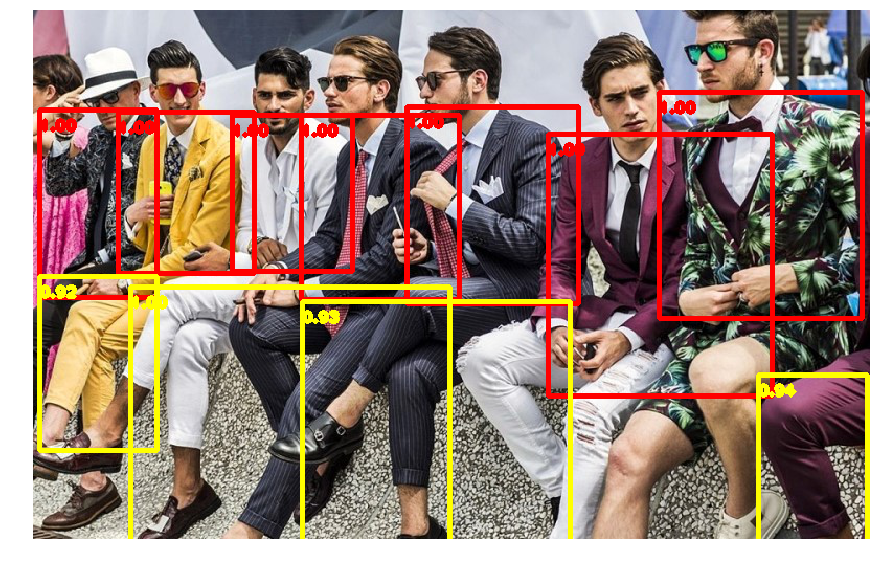

In [24]:
# img_path = '/Users/luke/Documents/ml_datasets/original/deepfashion/CategoryAttributePrediction/Img/img/1981_Graphic_Ringer_Tee/img_00000007.jpg'
img_path = '/Users/luke/Desktop/test_img/1.jpg'
# img_path = '/Users/luke/Desktop/test_img/000000554156.jpg'
# img_path = '../dataset/deepfashion/images/100000021448.jpg'
image = read_image_bgr(img_path)#skimage.io.imread(img_path)

draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image, min_side=600, max_side=1024)

_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))

predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]


# correct for image scale
detections[0, :, :4] /= scale

found_num = 0
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.9:
        continue

    found_num += 1
    b = detections[0, idx, :4].astype(int)
    
    color = [255,0,0]
    caption = "{:.2f}".format(score)
    if label == 1 or label == '1':
        color = [255,255,0]
        
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), color, 3)
    cv2.putText(draw, caption, (b[0], b[1] + 20), cv2.FONT_HERSHEY_PLAIN, 1, color, 3)
    
if not found_num == 0:
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

# VIDEOtag Dataset에서 검출되는 모든 Object 출력

In [25]:
import imageio


###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
img_total = len(vt_img_ary)

for img_idx, img_data in enumerate(vt_img_ary): 
    # NOTE : d_ -> detected_, a_ -> answer_
    
    print(str(img_idx)+'/'+str(img_total))
    img_id = img_data['id']

    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    a_vt_annos = getAnnosByImgId(img_id)

    if len(a_vt_annos) == 0:
        continue

    ###################################################################
    # videotag image 로드
    ###################################################################
    img_path = os.path.join(ROOT_DIR, args_image_dir, img_data['file_name']) 
    image = read_image_bgr(img_path)
    img_height, img_width = image.shape[:2]
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side=600, max_side=1024)
    
    ###################################################################
    # Run detection
    ###################################################################
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale
    
    found_num = 0
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.2:
            continue
            
        found_num += 1
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
#         caption = "{} {:.3f}".format(coco_class_names[label+1], score) # coco + deepfashion
#         caption = "{} {:.3f}".format(coco_class_names[label-1], score) # deepfahsion
        caption = "{} {:.3f}".format(coco_class_names[label], score) # deepfahsion(category3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
        
        
    if not found_num == 0:
        save_path = os.path.join(ROOT_DIR, args_image_log_dir, "deep", str(img_idx+100000000000).zfill(12)+'.jpg') 
        imageio.imwrite(save_path, draw)
        
#         plt.figure(figsize=(15, 15))
#         plt.axis('off')
#         plt.imshow(draw)
#         plt.show()

0/1081
1/1081
2/1081
3/1081
4/1081
5/1081
6/1081
7/1081
8/1081
9/1081
10/1081
11/1081
12/1081
13/1081
14/1081
15/1081
16/1081
17/1081
18/1081
19/1081
20/1081
21/1081
22/1081
23/1081
24/1081
25/1081
26/1081
27/1081
28/1081
29/1081
30/1081
31/1081
32/1081
33/1081
34/1081
35/1081
36/1081
37/1081
38/1081
39/1081
40/1081
41/1081
42/1081
43/1081
44/1081
45/1081
46/1081
47/1081
48/1081
49/1081
50/1081
51/1081
52/1081
53/1081
54/1081
55/1081
56/1081
57/1081
58/1081
59/1081
60/1081
61/1081
62/1081
63/1081
64/1081
65/1081
66/1081
67/1081
68/1081
69/1081
70/1081
71/1081
72/1081
73/1081
74/1081
75/1081
76/1081
77/1081
78/1081
79/1081
80/1081
81/1081
82/1081
83/1081
84/1081
85/1081
86/1081
87/1081
88/1081
89/1081
90/1081
91/1081
92/1081
93/1081
94/1081
95/1081
96/1081
97/1081
98/1081
99/1081
100/1081
101/1081
102/1081
103/1081
104/1081
105/1081
106/1081
107/1081
108/1081
109/1081
110/1081
111/1081
112/1081
113/1081
114/1081
115/1081
116/1081
117/1081
118/1081
119/1081
120/1081
121/1081
122/1081
123

924/1081
925/1081
926/1081
927/1081
928/1081
929/1081
930/1081
931/1081
932/1081
933/1081
934/1081
935/1081
936/1081
937/1081
938/1081
939/1081
940/1081
941/1081
942/1081
943/1081
944/1081
945/1081
946/1081
947/1081
948/1081
949/1081
950/1081
951/1081
952/1081
953/1081
954/1081
955/1081
956/1081
957/1081
958/1081
959/1081
960/1081
961/1081
962/1081
963/1081
964/1081
965/1081
966/1081
967/1081
968/1081
969/1081
970/1081
971/1081
972/1081
973/1081
974/1081
975/1081
976/1081
977/1081
978/1081
979/1081
980/1081
981/1081
982/1081
983/1081
984/1081
985/1081
986/1081
987/1081
988/1081
989/1081
990/1081
991/1081
992/1081
993/1081
994/1081
995/1081
996/1081
997/1081
998/1081
999/1081
1000/1081
1001/1081
1002/1081
1003/1081
1004/1081
1005/1081
1006/1081
1007/1081
1008/1081
1009/1081
1010/1081
1011/1081
1012/1081
1013/1081
1014/1081
1015/1081
1016/1081
1017/1081
1018/1081
1019/1081
1020/1081
1021/1081
1022/1081
1023/1081
1024/1081
1025/1081
1026/1081
1027/1081
1028/1081
1029/1081
1030/1081
1031/1

# Detection, VIDEOtag Points 모두 출력

In [55]:
###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
img_total = len(vt_img_ary)

for img_idx, img_data in enumerate(vt_img_ary): 
    # NOTE : d_ -> detected_, a_ -> answer_
    
#     if img_idx < 6:
#         continue
        
#     if img_idx > 100:
#         break

    img_id = img_data['id']

    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    a_vt_annos = getAnnosByImgId(img_id)

    if len(a_vt_annos) == 0:
        continue

    ###################################################################
    # videotag image이 로드
    ###################################################################
    img_path = os.path.join(ROOT_DIR, args_image_dir, img_data['file_name']) 
    image = read_image_bgr(img_path)
    img_height, img_width = image.shape[:2]
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side=600, max_side=1024)
    
    ###################################################################
    # Run detection
    ###################################################################
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    d_coco_cate_ids = np.argmax(detections[0, :, 4:], axis=1)#d_r['class_ids']
    d_scores = detections[0, np.arange(detections.shape[1]), 4 + d_coco_cate_ids]#d_r['scores']

    # correct for image scale
    detections[0, :, :4] /= scale

    # 확인용
    confirm_matching_classes = []
    confirm_vt_anno_points = []

    is_found = 0
    
    
    ###################################################################
    # Detection 표시
    ###################################################################
    for idx, (label, score) in enumerate(zip(d_coco_cate_ids, d_scores)):
        if score < 0.2:
            continue
            
        found_num += 1
        b = detections[0, idx, :4].astype(int)
        print('Detection bbox', b[0], b[1], b[2], b[3])
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
#         caption = "{} {:.3f}".format(coco_class_names[label+1], score) # coco, coco+deep
        caption = "{} {:.3f}".format(coco_class_names[label-1], score) # deep
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
    
    
   
        
    ###################################################################
    # VIDEOtag Point 출력
    ###################################################################
    for a_vt_anno in a_vt_annos:
        a_vt_anno_id = a_vt_anno['id']
        a_vt_cate_id = a_vt_anno['category_id']
        a_vt_cate_name = vt_coco_cate_map[a_vt_cate_id]['name']

        point_x = int(img_width * a_vt_anno['x_pos'])
        point_y = int(img_height * a_vt_anno['y_pos'])
        print('videotag', img_width, img_height, point_x, point_y)
        cv2.rectangle(draw, (point_x-5, point_y-5), (point_x+5, point_y+5), (255, 0, 0), 3)
        caption = "{}".format(a_vt_cate_name)
        cv2.putText(draw, caption, (point_x, point_y-10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 0, 0), 3)
        print(a_vt_cate_id, a_vt_cate_name)
                
#     plt.figure(figsize=(15, 15))
#     plt.axis('off')
#     plt.imshow(draw)
#     plt.show()
    
    save_path = os.path.join(ROOT_DIR, args_image_log_dir, 'deep', str(img_idx+100000000000).zfill(12)+'.jpg') 
    imageio.imwrite(save_path, draw)

    if len(confirm_matching_classes) > 0:
        print('매칭된 카테고리 확인 - ', confirm_matching_classes)
        print('----------------------------------------------------------------------')

KeyboardInterrupt: 

# Bbox 추출

In [54]:
###################################################################
# 모든 이미지에 대하여 predict를 실시한다.
###################################################################
img_total = len(vt_img_ary)

for img_idx, img_data in enumerate(vt_img_ary): 
    # NOTE : d_ -> detected_, a_ -> answer_
    
    if img_idx < 6:
        continue
        
#     if img_idx > 100:
#         break

    print(str(img_idx)+'/'+str(img_total))
    img_id = img_data['id']

    ###################################################################
    # videotag image에 등록되어 있느 annotation이 있는지 확인 후, 로드
    ###################################################################
    a_vt_annos = getAnnosByImgId(img_id)

    if len(a_vt_annos) == 0:
        continue

    ###################################################################
    # videotag image이 로드
    ###################################################################
    img_path = os.path.join(ROOT_DIR, args_image_dir, img_data['file_name']) 
    image = read_image_bgr(img_path)
    img_height, img_width = image.shape[:2]
    
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image, min_side=600, max_side=1024)
    
    ###################################################################
    # Run detection
    ###################################################################
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    d_coco_cate_ids = np.argmax(detections[0, :, 4:], axis=1)#d_r['class_ids']
    d_scores = detections[0, np.arange(detections.shape[1]), 4 + d_coco_cate_ids]#d_r['scores']

    # correct for image scale
    detections[0, :, :4] /= scale

    # 확인용
    confirm_matching_classes = []
    confirm_vt_anno_points = []

    is_found = 0
    
#     draw = image.copy()

    ###################################################################
    # 추출된 data를 VIDEOtag Annotation과 비교
    ###################################################################
    for d_idx, score in enumerate(d_scores):
        '''
        스코어 낮은 것은 의미가 없는 것으로 판단함
        아래에 VIDEOtag과 COCO의 데이타를 비교하는 로직이 있으므로 Predict의 정확도는
        현재 로직에서 의미가 없음
        '''
        
        if score < 0.2:
            continue

        d_coco_cate_id = d_coco_cate_ids[d_idx]
        d_coco_cate_name = coco_class_names[d_coco_cate_id-1]
        y1, x1, y2, x2 = detections[0, d_idx, :4].astype(int)
        d_bbox = [int(x1), int(y1), int(x2 - x1), int(y2 - y1)]
        
        ###################################################################
        # coco model에서 검출된 annotation들이 videotag annotation(정답)들과 비교하여
        # 일치할 경우가 있을 때, 해당 videotag annotation에 bbox정보를 추가한다.
        ###################################################################
        for a_vt_anno in a_vt_annos:
            a_vt_anno_id = a_vt_anno['id']
            a_vt_cate_id = a_vt_anno['category_id']
            a_vt_cate_name = vt_coco_cate_map[a_vt_cate_id]['name']

            point_x = int(img_width * a_vt_anno['x_pos'])
            point_y = int(img_height * a_vt_anno['y_pos'])

            # NOTE : 기대하는 VIDEOtag의 coco categories 확인. 현재(2018.02) 매칭되는 category가 많지 않다.
            a_coco_cate_ids = vt_coco_cate_map[a_vt_cate_id]['coco_ids']
            if len(a_coco_cate_ids) == 0:
                continue
                
            # NOTE: 포인트가 마스크 영역에 속하는 확인
            if point_x < x1 or point_x > x2 or point_y < y1 or point_y > y2:
                continue

            for a_coco_cate_id in a_coco_cate_ids:
                if a_coco_cate_id == d_coco_cate_id:
                    insertBboxToAnno(a_vt_anno_id, d_bbox)
                    
                    confirm_vt_anno_points.append([point_y-5, point_x-5, point_y+5, point_x+5])
                    confirm_matching_classes.append([d_coco_cate_name, a_vt_cate_name])
                    
                    cv2.rectangle(draw, (y1, x1), (y2, x2), (0, 0, 255), 3)
                    caption = "{} {:.3f}".format(d_coco_cate_name, score)
                    cv2.putText(draw, caption, (y1, x1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
                    cv2.rectangle(draw, (point_x-5, point_y-5), (point_x+5, point_y+5), (0, 0, 255), 3)
                    cv2.putText(draw, a_vt_cate_id, (point_x, point_y - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 255), 2)
                    
                    is_found = 1
                    break
                
    if len(confirm_vt_anno_points) > 0:
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

    if len(confirm_matching_classes) > 0:
        print('매칭된 카테고리 확인 - ', confirm_matching_classes)
        print('----------------------------------------------------------------------')

6/1081


KeyboardInterrupt: 

In [ ]:
## result_json = {}
result_json['annotations'] = vt_anno_ary
result_json['images'] = vt_img_ary

with open('../dataset/videotag/0101_0102/result/instances.json', 'w') as outfile:
    json.dump(result_json, outfile)